In [1]:
# Core 
import datetime
import os
import glob
import tempfile
import shutil
import sys
import pickle
import warnings

# Analysis 
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sp

# Plotting
import matplotlib.pyplot as plt

# Debugging 
import pdb, traceback
%load_ext line_profiler

# Radar Tools
import pyart
import tint
from tint import animate


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
def CPOL_files_from_datetime_list(datetimes):
    print('Gathering files.')
    base = '/g/data/rr5/CPOL_radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/'
    filenames = []
    for i in range(len(datetimes)):
        year = str(datetimes[i])[0:4]
        month = str(datetimes[i])[5:7]
        day = str(datetimes[i])[8:10]
        hour = str(datetimes[i])[11:13]
        minute = str(datetimes[i])[14:16]
        filename = (base + '{0}/{0}{1}{2}/'.format(year, month, day) 
                    + 'CPOL_{0}{1}{2}'.format(year, month, day)
                    + '_{}{}_GRIDS_2500m.nc'.format(hour, minute))
        if os.path.isfile(filename):
            filenames.append(filename)
    
    return sorted(filenames), datetimes[0], datetimes[-1]
    
def CPOL_files_from_TINT_obj(tracks_obj, uid):
    datetimes = tracks_obj.system_tracks.xs(uid, level='uid')
    datetimes = datetimes.reset_index(level='time')['time']
    datetimes = list(datetimes.values)
    [files, start_date, end_date] = CPOL_files_from_datetime_list(datetimes)
    
    return files, start_date, end_date

def get_square_boundary(grid):
    b_ind = set()
    columns = grid.nx
    rows = grid.ny
    for edge in [[0, columns], [rows-1, columns],
                 [rows, 0], [rows, columns-1]]:
        b = np.array([[edge[0]]*edge[1], list(range(edge[1]))])
        b = b.transpose().tolist()
        b = set([tuple(b[i]) for i in range(edge[1])])
        b_ind = b_ind.union(b)
    return b_ind

def get_circular_boundary(grid):
    radius = grid.x['data'][-1]
    # Assume a regular grid
    dx = grid.x['data'][1] - grid.x['data'][0]
    offset = np.sqrt(2*dx**2)
    X, Y = np.meshgrid(grid.x['data'], grid.y['data'], indexing='ij')
    radii = np.sqrt(X**2+Y**2)
    
    b_ind = np.argwhere(np.logical_and(radii >= radius, 
                                       radii < radius + dx))
    b_ind_set = set([tuple(b_ind[i]) for i in range(b_ind.shape[0])])
        
    plt.pcolor(np.logical_and(radii >= radius-offset/2, 
                              radii < radius+offset/2))
    return b_ind_set

In [3]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_test.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [4]:
filenames = CPOL_files_from_datetime_list(np.arange(np.datetime64('2006-02-10 11:40'), 
                                          np.datetime64('2006-02-10 12:30'), 
                                          np.timedelta64(10, 'm')))[0]
# Generate grid generator 
# Note generators produce iterators
# These are alternative to using lists and looping
grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity') 
         for fn in filenames)

with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/circ_b_ind_set.pkl', 'rb') as f:
    b_ind_set = pickle.load(f)

# Define settings for tracking
settings = {
    'MIN_SIZE' : [1, 1, 1000, 1000],
    'FIELD_THRESH' : [40, 20, 15, 15],
    'ISO_THRESH' : [5, 5, 5, 5],
    'GS_ALT' : 1500,
    'SEARCH_MARGIN' : 10000,
    'FLOW_MARGIN' : 40000,
    'LEVELS' : np.array(
        [[0, 2500], 
         [2500, 5000],
         [5000, 7500],
         [7500, 10000]]
    ),
    'TRACK_INTERVAL' : 0,
    'BOUNDARY_GRID_CELLS' : b_ind_set
}

# Calculate high and low level tracks
tracks_obj  = tint.Cell_tracks()

for parameter in ['MIN_SIZE', 'FIELD_THRESH', 'GS_ALT', 'LEVELS', 
                  'TRACK_INTERVAL', 'ISO_THRESH', 'SEARCH_MARGIN',
                  'FLOW_MARGIN', 'BOUNDARY_GRID_CELLS'
                 ]:
    tracks_obj.params[parameter] = settings[parameter]

# Calculate tracks
tracks_obj.get_tracks(grids)

# Create directory for figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")  

out_file_name = ('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/'
                 + 'tracks_obj_{}.pkl'.format(dt))

with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)

Gathering files.
> /home/563/esh563/TINT/tint/matching.py(243)match_pairs()
-> obj_merge = [set() for i in range(obj_match.shape[1])]
(Pdb) n
> /home/563/esh563/TINT/tint/matching.py(246)match_pairs()
-> pairs = optimize.linear_sum_assignment(obj_match)
(Pdb) n
> /home/563/esh563/TINT/tint/matching.py(248)match_pairs()
-> for id1 in pairs[0]:
(Pdb) n
> /home/563/esh563/TINT/tint/matching.py(249)match_pairs()
-> if obj_match[id1, pairs[1][id1]] > params['MAX_DISPARITY']:
(Pdb) n
> /home/563/esh563/TINT/tint/matching.py(248)match_pairs()
-> for id1 in pairs[0]:
(Pdb) n
> /home/563/esh563/TINT/tint/matching.py(249)match_pairs()
-> if obj_match[id1, pairs[1][id1]] > params['MAX_DISPARITY']:
(Pdb) n
> /home/563/esh563/TINT/tint/matching.py(251)match_pairs()
-> pairs[1][id1] = -1
(Pdb) n
> /home/563/esh563/TINT/tint/matching.py(253)match_pairs()
-> id2 = np.argmin(obj_match[id1])
(Pdb) n
> /home/563/esh563/TINT/tint/matching.py(256)match_pairs()
-> if obj_match[id1, id2] < LARGE_NUM:
(Pdb) n

BdbQuit: 

Gathering files.
Animating from 2006-02-10T11:40:08.000000000 to 2006-02-10T12:20:08.000000000.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-981889839e81>", line 33, in <module>
    tracers=True, keep_frames=False, dpi=100, alt=7500)
  File "/home/563/esh563/TINT/tint/visualization.py", line 461, in animate
    **kwargs)
  File "/home/563/esh563/TINT/tint/visualization.py", line 184, in full_domain
    bbox_inches = 'tight', dpi=dpi)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/matplotlib/pyplot.py", line 695, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/matplotlib/figure.py", line 2062, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6

KeyboardInterrupt: 

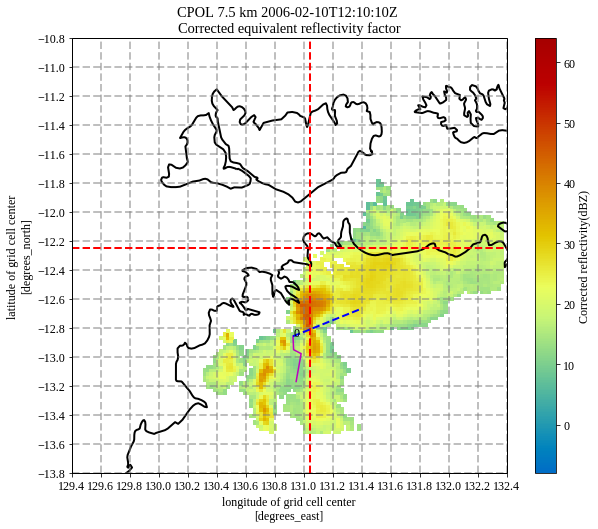

In [5]:
lon_min = 131.0 - 1.6
lon_max = 131.0 + 1.6

lat_max = -12.2 + 1.6
lat_min = -12.2 - 1.6

# [filenames, start_time, end_time] = CPOL_files_from_datetime_list(np.arange(np.datetime64('2006-02-12 15'), 
#                                                                 np.datetime64('2006-02-12 18'), 
#                                                                 np.timedelta64(10, 'm')))

filenames, start_time, end_time = CPOL_files_from_TINT_obj(tracks_obj, '0')

# Generate grid generator 
# Note generators produce iterators
# These are alternative to using lists and looping
grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
         for fn in filenames)

# Create directory for figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")

base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
out_path = base_path + dt + '_tint_CPOL_anim'

animate(tracks_obj, grids, out_path,
        start_datetime = start_time,
        end_datetime = end_time,
        lat_lines=np.arange(lat_min, lat_max, .2),
        lon_lines=np.arange(lon_min, lon_max, .2),
        tracers=True, keep_frames=False, dpi=100, alt=7500)

In [25]:
# Let's filter by tilt direction and magnitude
forward_tilt = ((-45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 45))
backward_tilt = ((-45 >= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                | (tracks_obj.system_tracks['sys_rel_tilt_dir'] >= 45))
left_tilt = ((45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 135))
right_tilt = ((-135 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= -45))
sig_tilt_mag = (tracks_obj.system_tracks['tilt_mag'] >= 2000)

In [4]:
# Let's find the cells that were tracked for the most frames
tracks_obj.system_tracks.groupby(level='uid').size().sort_values(ascending=False)[:20]

uid
0    27
1    11
2     1
dtype: int64

In [24]:
tracks_obj.system_tracks['touch_border'].xs('0', level='uid')

scan  time               
0     2006-02-10 10:00:09     3
1     2006-02-10 10:10:10     5
2     2006-02-10 10:20:09     5
3     2006-02-10 10:30:09     6
4     2006-02-10 10:40:09     8
5     2006-02-10 10:50:09    10
6     2006-02-10 11:00:09     9
7     2006-02-10 11:10:09    10
8     2006-02-10 11:20:08    13
9     2006-02-10 11:30:08    14
10    2006-02-10 11:40:08    12
11    2006-02-10 11:50:13    22
12    2006-02-10 12:00:09    16
13    2006-02-10 12:10:10    21
14    2006-02-10 12:20:08    19
15    2006-02-10 12:30:08    14
16    2006-02-10 12:40:08     8
17    2006-02-10 12:50:13     5
18    2006-02-10 13:00:09     6
19    2006-02-10 13:10:10     5
20    2006-02-10 13:20:08     5
21    2006-02-10 13:30:08     6
22    2006-02-10 13:40:08     5
23    2006-02-10 13:50:09     6
24    2006-02-10 14:00:09     6
25    2006-02-10 14:10:10     6
26    2006-02-10 14:20:09     6
Name: touch_border, dtype: int64

In [59]:
uid = '4'

filenames, start_time, end_time = CPOL_files_from_TINT_obj(tracks_obj, uid)

grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator

# Create directory for figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")

base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
out_path = base_path + dt + '_tint_CPOL_lagrangian'
animate(tracks_obj, grids, out_path, style='lagrangian', uid=uid, 
        alt_low=4000, alt_high=6000, keep_frames=False, dpi=100)

Gathering files.
Animating 27 frames
Plotting frame at 2006-02-09T09:50:08
Creating GIF - may take a few minutes.
